# 10y Bond Forecasting with LSTMs

In [23]:
import os
import sys
import pandas as pd
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Bidirectional, LSTM, GRU
from keras import backend as K
import tensorflow as tf
from tensorflow.python.client import device_lib
from bokeh.io import output_notebook
from utils import (get_number_processors, plot_series, to_1dimension, plot_series_prediction, plot_model_history, save_model, mean_absolute_percentage_error)
#import h5py

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tf.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())

%load_ext autoreload
%autoreload 2

output_notebook()

OS:  linux
Python:  3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]
Keras:  2.1.5
Tensorflow:  1.4.0
Numpy:  1.14.2
Number of CPU processors:  4
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [24]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3890093537532141978
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 234356736
locality {
  bus_id: 1
}
incarnation: 6164251186186115336
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [25]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Data

In [26]:
VERSION = '01.1'

In [27]:
DATA = os.path.join('data', 'test_bond.csv')
SAVE_DIR = 'models'
EPOCHS = 150
TEST_SIZE = 0.3
TIME_AHEAD = 1 #prediction step
BATCH_SIZE = 1
UNITS = 25
OPT = 'adagrad'

In [28]:
df_bond = pd.read_csv(DATA)

In [29]:
print(df_bond.shape)

(14362, 2)


In [30]:
df_bond.head()

,date,10Y Bond
0,2018-03-01,2.848
1,2018-02-28,2.864
2,2018-02-27,2.901
3,2018-02-26,2.864
4,2018-02-25,2.875


In [31]:
df_bond.tail()

,date,10Y Bond
14357,1952-12-31,2.68
14358,1951-12-31,2.57
14359,1950-12-29,2.32
14360,1949-12-30,2.47
14361,1948-12-31,2.49


In [32]:
df_bond['datetime'] = pd.to_datetime(df_bond.date)

In [33]:
df_bond.sort_values(by='datetime', ascending=True, inplace=True)

In [34]:
df_bond.head()

,date,10Y Bond,datetime
14361,1948-12-31,2.49,1948-12-31
14360,1949-12-30,2.47,1949-12-30
14359,1950-12-29,2.32,1950-12-29
14358,1951-12-31,2.57,1951-12-31
14357,1952-12-31,2.68,1952-12-31


In [35]:
df_bond.tail()

,date,10Y Bond,datetime
4,2018-02-25,2.875,2018-02-25
3,2018-02-26,2.864,2018-02-26
2,2018-02-27,2.901,2018-02-27
1,2018-02-28,2.864,2018-02-28
0,2018-03-01,2.848,2018-03-01


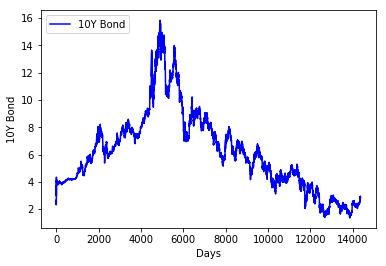

In [36]:
bond = df_bond['10Y Bond']
plot_series(bond, xlabel='Days', ylabel='10Y Bond', color='b', legend='10Y Bond')

In [37]:
scaler = MinMaxScaler(feature_range=(0, 1)) #other typical scale values are -1,1
bond = scaler.fit_transform(np.reshape(bond, (len(bond),1)))

/home/temenid/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


In [38]:
train, test = train_test_split(bond, test_size=TEST_SIZE, shuffle=False)
print(train.shape)
print(test.shape)

(10053, 1)
(4309, 1)


In [39]:
test[:-5]

array([[0.26964508],
       [0.265502  ],
       [0.2679188 ],
       ...,
       [0.11006767],
       [0.10778898],
       [0.10412926]])

In [40]:
X_train, y_train = to_1dimension(train, TIME_AHEAD)
X_test, y_test = to_1dimension(test, TIME_AHEAD)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10051, 1, 1) (10051,)
(4307, 1, 1) (4307,)


### LSTM

In [41]:
model_name = 'keras_' + 'lstm' + '_' + 'units_' + str(UNITS) + '_' + 'opt_' + OPT + '_v'+ VERSION + 'trained_model.h5'

In [42]:
def create_symbol(model_name='LSTM', units=10, activation='linear', time_ahead=1):
    model = Sequential()
    if model_name == 'LSTM':
        model.add(LSTM(units, input_shape=(1, time_ahead)))
    elif model_name == 'BiLSTM':
        model.add(Bidirectional(LSTM(units), input_shape=(1, time_ahead)))
    elif model_name == 'GRU':
        model.add(GRU(units, input_shape=(1, time_ahead)))
    else:
        raise ValueError("Wrong model name")
    model.add(Dense(1))
    model.add(Activation('linear'))
    return model

In [43]:
lstm_model = create_symbol(model_name='LSTM', units=UNITS, time_ahead=TIME_AHEAD)
lstm_model.compile(optimizer=OPT, loss='mean_squared_error', metrics=['accuracy']) 

In [44]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/150
 - 31s - loss: 0.0019 - acc: 9.9493e-05
Epoch 2/150
 - 30s - loss: 4.7202e-05 - acc: 9.9493e-05
Epoch 3/150
 - 30s - loss: 4.2986e-05 - acc: 9.9493e-05
Epoch 4/150
 - 30s - loss: 3.9720e-05 - acc: 9.9493e-05
Epoch 5/150
 - 30s - loss: 3.7178e-05 - acc: 9.9493e-05
Epoch 6/150
 - 30s - loss: 3.5170e-05 - acc: 9.9493e-05
Epoch 7/150
 - 30s - loss: 3.3400e-05 - acc: 9.9493e-05
Epoch 8/150
 - 30s - loss: 3.2152e-05 - acc: 9.9493e-05
Epoch 9/150
 - 30s - loss: 3.1093e-05 - acc: 9.9493e-05
Epoch 10/150
 - 30s - loss: 3.0182e-05 - acc: 9.9493e-05
Epoch 11/150
 - 30s - loss: 2.9457e-05 - acc: 9.9493e-05
Epoch 12/150
 - 30s - loss: 2.8895e-05 - acc: 9.9493e-05
Epoch 13/150
 - 30s - loss: 2.8382e-05 - acc: 9.9493e-05
Epoch 14/150
 - 30s - loss: 2.8000e-05 - acc: 9.9493e-05
Epoch 15/150
 - 30s - loss: 2.7738e-05 - acc: 9.9493e-05
Epoch 16/150
 - 30s - loss: 2.7427e-05 - acc: 9.9493e-05
Epoch 17/150
 - 30s - loss: 2.7233e-05 - acc: 9.9493e-05
Epoch 18/150
 - 30s - loss: 2.7045e-05 - acc

 - 29s - loss: 2.6084e-05 - acc: 9.9493e-05
Epoch 145/150
 - 29s - loss: 2.6065e-05 - acc: 9.9493e-05
Epoch 146/150
 - 29s - loss: 2.6085e-05 - acc: 9.9493e-05
Epoch 147/150
 - 29s - loss: 2.6087e-05 - acc: 9.9493e-05
Epoch 148/150
 - 29s - loss: 2.6093e-05 - acc: 9.9493e-05
Epoch 149/150
 - 29s - loss: 2.6069e-05 - acc: 9.9493e-05
Epoch 150/150
 - 29s - loss: 2.6068e-05 - acc: 9.9493e-05


In [45]:
#lstm_history.history

In [46]:
# plot model history
#plot_model_history(lstm_history)

`pred_test` will have a shape of `(num_rows, TIME_AHEAD)`, having the predicted values for the next `TIME_AHEAD` days.

In [47]:
y_test_inv = scaler.inverse_transform([y_test])
bond_inv = scaler.inverse_transform(bond)

In [50]:
pred_test = lstm_model.predict(X_test) #pred_test.shape = (num_rows, TIME_AHEAD)
pred_test = scaler.inverse_transform(pred_test)
score = math.sqrt(mean_squared_error(y_test_inv[0], pred_test[:,0]))
print('Test RMSE: %.3f' % (score))

Test RMSE: 0.069


In [52]:
mape = mean_absolute_percentage_error(y_test_inv[0],pred_test[:,0])
print('Test MAPE: %.3f' % (mape))

Test MAPE: 2.053


In [53]:
save_model(lstm_model, SAVE_DIR, model_name)

Saved trained model at models/keras_lstm_units_25_opt_adagrad_v01.1trained_model.h5 


In [54]:
pred_train = lstm_model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
plot_series_prediction(bond_inv, pred_train, pred_test, time_ahead=TIME_AHEAD,
                       title='LSTM_prediction', xlabel='Days', ylabel='10Y Bond', 
                       legend=['True value','Training set','Test prediction'])

### BiLSTM
Now we can try with a Bi-directional LSTM (BiLSTM).

In [55]:
model_name = 'keras_' + 'BiLSTM' + '_' + 'units_' + str(UNITS) + '_' + 'opt_' + OPT + '_v'+ VERSION + '_' + 'trained_model.h5'

In [56]:
bilstm_model = create_symbol(model_name='BiLSTM', units=UNITS, time_ahead=TIME_AHEAD)
bilstm_model.compile(optimizer=OPT, loss='mean_squared_error', metrics=['accuracy']) 

In [57]:
bilstm_history = bilstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=1, verbose=2)

Epoch 1/150
 - 47s - loss: 7.9168e-04 - acc: 9.9493e-05
Epoch 2/150
 - 46s - loss: 3.8648e-05 - acc: 9.9493e-05
Epoch 3/150
 - 47s - loss: 3.6037e-05 - acc: 9.9493e-05
Epoch 4/150
 - 46s - loss: 3.4177e-05 - acc: 9.9493e-05
Epoch 5/150
 - 47s - loss: 3.2647e-05 - acc: 9.9493e-05
Epoch 6/150
 - 47s - loss: 3.1481e-05 - acc: 9.9493e-05
Epoch 7/150
 - 47s - loss: 3.0545e-05 - acc: 9.9493e-05
Epoch 8/150
 - 46s - loss: 2.9766e-05 - acc: 9.9493e-05
Epoch 9/150
 - 47s - loss: 2.9109e-05 - acc: 9.9493e-05
Epoch 10/150
 - 46s - loss: 2.8657e-05 - acc: 9.9493e-05
Epoch 11/150
 - 46s - loss: 2.8232e-05 - acc: 9.9493e-05
Epoch 12/150
 - 46s - loss: 2.7901e-05 - acc: 9.9493e-05
Epoch 13/150
 - 46s - loss: 2.7655e-05 - acc: 9.9493e-05
Epoch 14/150
 - 46s - loss: 2.7428e-05 - acc: 9.9493e-05
Epoch 15/150
 - 46s - loss: 2.7214e-05 - acc: 9.9493e-05
Epoch 16/150
 - 46s - loss: 2.7091e-05 - acc: 9.9493e-05
Epoch 17/150
 - 46s - loss: 2.6961e-05 - acc: 9.9493e-05
Epoch 18/150
 - 47s - loss: 2.6878e-05 -

 - 47s - loss: 2.6114e-05 - acc: 9.9493e-05
Epoch 145/150
 - 46s - loss: 2.6135e-05 - acc: 9.9493e-05
Epoch 146/150
 - 46s - loss: 2.6107e-05 - acc: 9.9493e-05
Epoch 147/150
 - 47s - loss: 2.6106e-05 - acc: 9.9493e-05
Epoch 148/150
 - 47s - loss: 2.6078e-05 - acc: 9.9493e-05
Epoch 149/150
 - 47s - loss: 2.6085e-05 - acc: 9.9493e-05
Epoch 150/150
 - 47s - loss: 2.6108e-05 - acc: 9.9493e-05


In [58]:
# plot model history
#plot_model_history(bilstm_history)

In [59]:
pred_test = bilstm_model.predict(X_test)
pred_test = scaler.inverse_transform(pred_test)
score = math.sqrt(mean_squared_error(y_test_inv[0], pred_test[:,0]))
print('Test RMSE: %.3f' % (score))

Test RMSE: 0.067


In [60]:
mape = mean_absolute_percentage_error(y_test_inv[0],pred_test[:,0])
print('Test MAPE: %.3f' % (mape))

Test MAPE: 1.912


In [61]:
save_model(bilstm_model, SAVE_DIR, model_name)

Saved trained model at models/keras_BiLSTM_units_25_opt_adagrad_v01.1_trained_model.h5 


In [62]:
pred_train = bilstm_model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
plot_series_prediction(bond_inv, pred_train, pred_test, time_ahead=TIME_AHEAD,
                       title='BiLSTM_prediction', xlabel='Days', ylabel='10Y Bond', 
                       legend=['True value','Training set','Test prediction'])

### GRU
Finally, we are going to try with a [Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) (GRU), which is a simplified version of LSTM.

In [63]:
model_name = 'keras_' + 'GRU' + '_' + 'units_' + str(UNITS) + '_' + 'opt_' + OPT + '_v'+ VERSION  + '_' + 'trained_model.h5'

In [64]:
gru_model = create_symbol(model_name='GRU', units=UNITS, time_ahead=TIME_AHEAD)
gru_model.compile(optimizer=OPT, loss='mean_squared_error', metrics=['accuracy']) 

In [65]:
gru_history = gru_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=1, verbose=2)

Epoch 1/150
 - 27s - loss: 5.4462e-04 - acc: 9.9493e-05
Epoch 2/150
 - 27s - loss: 2.7746e-05 - acc: 9.9493e-05
Epoch 3/150
 - 27s - loss: 2.7543e-05 - acc: 9.9493e-05
Epoch 4/150
 - 27s - loss: 2.7412e-05 - acc: 9.9493e-05
Epoch 5/150
 - 27s - loss: 2.7257e-05 - acc: 9.9493e-05
Epoch 6/150
 - 27s - loss: 2.7113e-05 - acc: 9.9493e-05
Epoch 7/150
 - 27s - loss: 2.7131e-05 - acc: 9.9493e-05
Epoch 8/150
 - 27s - loss: 2.6944e-05 - acc: 9.9493e-05
Epoch 9/150
 - 27s - loss: 2.6938e-05 - acc: 9.9493e-05
Epoch 10/150
 - 27s - loss: 2.6808e-05 - acc: 9.9493e-05
Epoch 11/150
 - 27s - loss: 2.6770e-05 - acc: 9.9493e-05
Epoch 12/150
 - 27s - loss: 2.6744e-05 - acc: 9.9493e-05
Epoch 13/150
 - 27s - loss: 2.6680e-05 - acc: 9.9493e-05
Epoch 14/150
 - 27s - loss: 2.6610e-05 - acc: 9.9493e-05
Epoch 15/150
 - 27s - loss: 2.6616e-05 - acc: 9.9493e-05
Epoch 16/150
 - 27s - loss: 2.6582e-05 - acc: 9.9493e-05
Epoch 17/150
 - 27s - loss: 2.6534e-05 - acc: 9.9493e-05
Epoch 18/150
 - 27s - loss: 2.6483e-05 -

 - 26s - loss: 2.6077e-05 - acc: 9.9493e-05
Epoch 145/150
 - 27s - loss: 2.6068e-05 - acc: 9.9493e-05
Epoch 146/150
 - 26s - loss: 2.6035e-05 - acc: 9.9493e-05
Epoch 147/150
 - 27s - loss: 2.6076e-05 - acc: 9.9493e-05
Epoch 148/150
 - 27s - loss: 2.6110e-05 - acc: 9.9493e-05
Epoch 149/150
 - 27s - loss: 2.6049e-05 - acc: 9.9493e-05
Epoch 150/150
 - 26s - loss: 2.6064e-05 - acc: 9.9493e-05


In [66]:
# plot model history
#plot_model_history(gru_history)

In [67]:
pred_test = gru_model.predict(X_test)
pred_test = scaler.inverse_transform(pred_test)
score = math.sqrt(mean_squared_error(y_test_inv[0], pred_test[:,0]))
print('Test RMSE: %.3f' % (score))

Test RMSE: 0.062


In [68]:
mape = mean_absolute_percentage_error(y_test_inv[0],pred_test[:,0])
print('Test MAPE: %.3f' % (mape))

Test MAPE: 1.684


In [69]:
save_model(gru_model, SAVE_DIR, model_name)

Saved trained model at models/keras_GRU_units_25_opt_adagrad_v01.1_trained_model.h5 


In [70]:
pred_train = gru_model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
plot_series_prediction(bond_inv, pred_train, pred_test, time_ahead=TIME_AHEAD,
                       title='GRU_prediction', xlabel='Days', ylabel='10Y Bond', 
                       legend=['True value','Training set','Test prediction'])